# EEG Preprocessing

### Experiment
What happeneded ...

## the workflow of this document
1. Data 
2. High pass low pass 
3. Ica 
4. Fjern dårlige ica’er
5. Fjern channels der stadig er dårlige 
6. Fiks artifacts 
7. Lav epochs 
8. Tjek ERP’s ud 
=> T-test mellem erps 

## Loading modules & data

In [2]:
# importing modules
import os
import numpy as np
import mne
import pandas

In [2]:
os. getcwd()

'/Users/laura/Google Drev/UNI 4.0/NEURO/EEG EXAM'

In [3]:
### LOADING IN REACTIONS TIMES
dat_behave = pandas.read_csv('/Users/laura/Google Drev/UNI 4.0/NEURO/EEG EXAM/behave_data_neuro.csv')
overlay_rt_behave = dat_behave['rt']
order = np.argsort(overlay_rt_behave)

## Loading in the EEG data

In [4]:
# trying to load the local data
raw_data = mne.io.read_raw_brainvision("Group6_own.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=True, verbose=None)
raw_data.info['bads'] = []

Extracting parameters from Group6_own.vhdr...
Setting channel info structure...
Reading 0 ... 758999  =      0.000 ...   758.999 secs...


In [5]:
### LOOKINIG AT THE RAW DATA:
raw_data.load_data()

<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.3 MB, data loaded>

Looking at the ouput from the load.data() function, try to figure out:

How many EEG channels?
- 30 EEG channels !!!

Do you see any EEG channels marked as bad during recording?
- Nope

What is the sampling frequency?
- 1000, which means that we have 1000 samples per second 

How many minutes of data were recorded?
- 12,38 minutes 

## specifying the channels location 
this is done by using the montage

In [5]:
montage = mne.channels.make_standard_montage('standard_1020')
raw_data.set_montage(montage, verbose=False)

<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


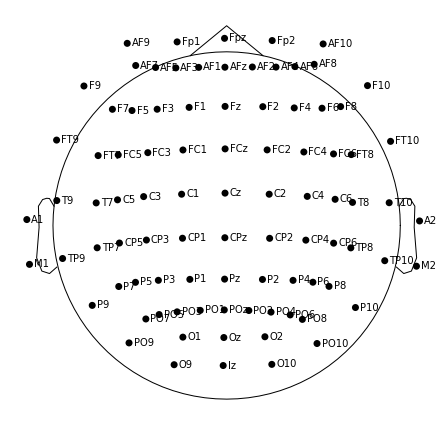

In [6]:
mne.viz.plot_montage(montage, scale_factor=20, show_names=True, kind='topomap', show=True, sphere=None, verbose=None);

In [7]:
# redefining the reference to a common average
raw_data.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

# DATA TIME - lets look at the raw data ..
### and maybe exclude a few channels

Using matplotlib as 2D backend.
Opening raw-browser...


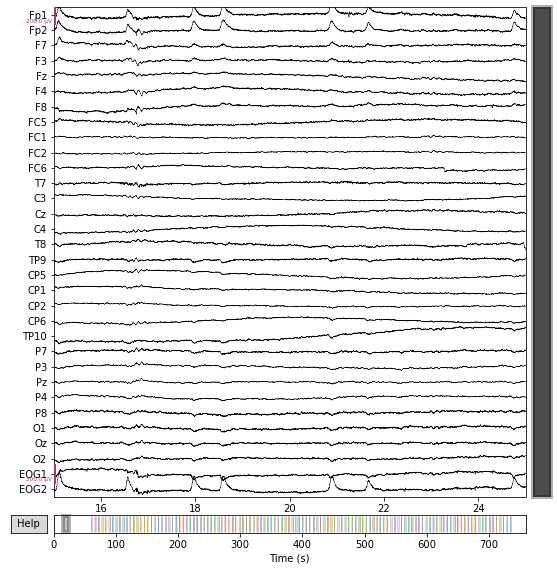

In [8]:
mne.viz.plot_raw(raw_data, n_channels = 32, scalings = dict(eeg = 0.0001), start = 15, duration = 10);

In [9]:
# selecting only EEG and stimulus data & plotting raw data
raw_data.pick_types(meg=False, eeg=True, stim=True, eog = True, exclude=[])
raw_data.plot(n_channels=32);


Opening raw-browser...


In [10]:
#raw_data.ch_names 

One could argue that some channels doesn't look to good. However, these are not excluded yet, instead I make ICA to see if I can make the data usable without excluding valuable information. 

Before making the ICA filtering, I highpass/lowpass filter the raw data:

In [11]:
raw_data.pick_types(meg=False, eeg=True, eog=True, stim=True, exclude=[])

<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

Now it's gone! Let's move on to filtering the data in order to enhance the signal.

## Filtering
We high-pass filter the data at 0.1 Hz and low-pass filter the data at 40 Hz, following the typical practices of EEG preprocessing. The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts)), with frequencies higher than the frequencies of the signal we are interested in.

In [9]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
data_fil = raw_data.copy().filter(0.1, None)
data_fil = data_fil.copy().filter(None, 40)

# plotting the filtered data for inspection
data_fil.plot(n_channels=32);
data_fil.pick_types(meg=False, eeg=True, stim=True, exclude=[], eog = True)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Opening raw-browser...


<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

# ICA TIME BABY
now that I have filtered, I want to use ICA to make sure the data is as 'clean' and with as few artefacts as possible. 

#### Independent component analysis (ICA)
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [10]:
# set up and fit the ica with 800 iterations with a random seed at 97
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(data_fil)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 20 components


/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 300.2s.


<ICA | raw data decomposition, method: fastica (fit in 800 iterations on 759000 samples), 20 ICA components explaining 95.2 % of variance (30 PCA components available), channel types: eeg, no sources marked for exclusion>

In [12]:

# plotting the ica components
ica.plot_components();

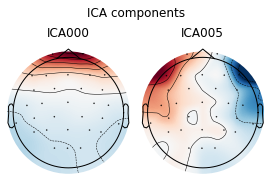

In [11]:

# plotting the ica components i believe looks too weird 
ica.plot_components([0,5]);

In [13]:
# plotting the time series of the ica
ica.plot_sources(data_fil, show_scrollbars=False, start = 130, stop = 150);


Creating RawArray with float64 data, n_channels=22, n_times=759000
    Range : 0 ... 758999 =      0.000 ...   758.999 secs
Ready.
Opening ica-browser...


Creating RawArray with float64 data, n_channels=4, n_times=759000
    Range : 0 ... 758999 =      0.000 ...   758.999 secs
Ready.
Opening ica-browser...


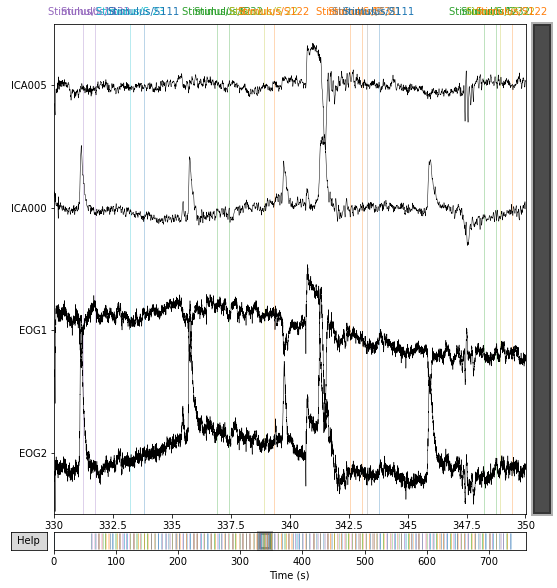

In [ ]:
ica.plot_sources(data_fil, picks=[5,0], start = 330, stop = 350);


#### Excluding ICA's

Creating RawArray with float64 data, n_channels=22, n_times=759000
    Range : 0 ... 758999 =      0.000 ...   758.999 secs
Ready.
Opening ica-browser...


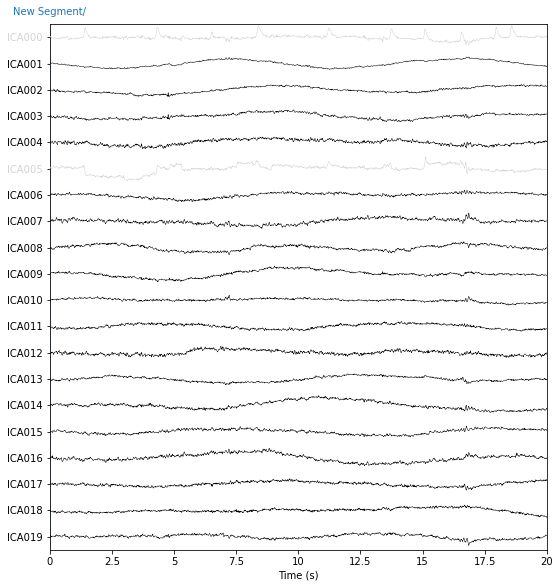

In [14]:
# the first component is excluded based on visual inspection
ica.exclude = [0,5]
ica.plot_sources(data_fil, show_scrollbars=False);



### Using the ICA on the RAW DATA
this is done to the data that has only been high/low pass filtered ... dunno if it should be the raw.

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Opening raw-browser...


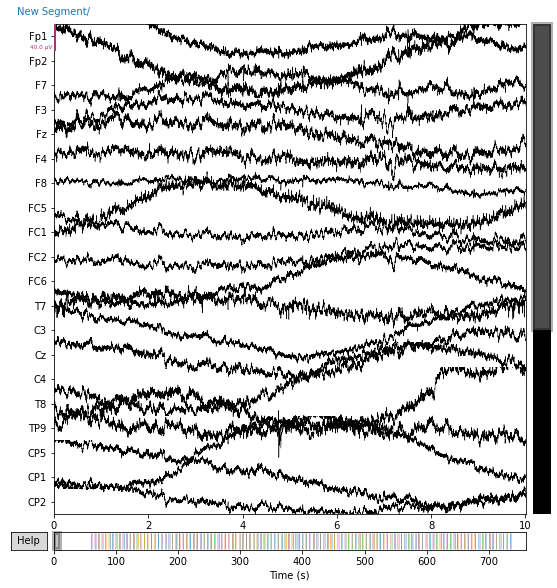

In [15]:
# applying the ica to the data
data_ica = ica.apply(raw_data)

# plotting the data after filtering and ica
data_ica.plot();


Opening raw-browser...


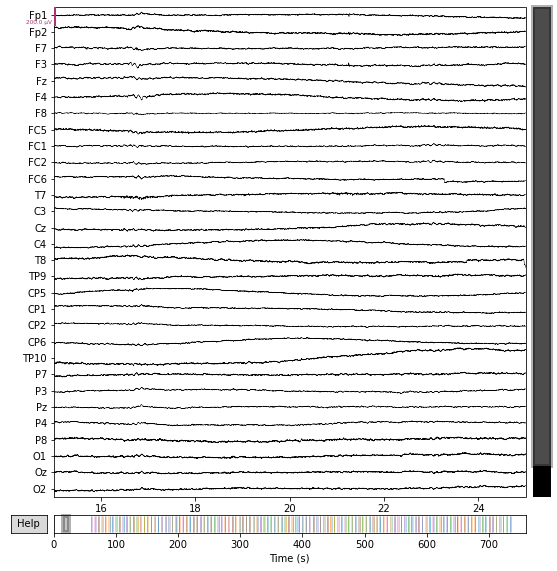

In [16]:
mne.viz.plot_raw(data_ica, n_channels = 30, scalings = dict(eeg = 0.0001), start = 15, duration = 10);

Now that we have saved the ICA data, we can check whether there are still channels that are to noisy or with to little signal to be used.

## FILTER TIME ONCE AGAIN
originally I was to remove bad channels here, but prefer to keep them in and instead filter again, 

When plotting all 30 channels, you should be able to see that one channel seems bad (i.e. it is pretty flat). We want to mark it is bad in our data.

In [17]:
## PLOTTING ALL SIMULTANEOUSLY 
data_ica.pick_types(meg=False, eeg=True, stim=True, exclude=[], eog = True)
data_ica.plot(n_channels=32, start = 150);

Opening raw-browser...


Now this data is still quite messy, and I will thus apply the highpass lowpass filter once again:


In [18]:
# filtering the ICA data:
ica_data_fil = data_ica.copy().filter(0.1, None)
ica_data_fil = ica_data_fil.copy().filter(None, 40)

# plotting the filtered data for inspection
ica_data_fil.plot(n_channels=32);
ica_data_fil.pick_types(meg=False, eeg=True, stim=True, exclude=[], eog = True)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Opening raw-browser...


<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

Now that we have marked the two channels as bad, we can exclude it. 

Now that I have a somewhat clean dataset I run artefact detection and make the epochs and ERP's

## Artefact detection
There are many ways to detect and deal with artefacts. In this case I simply choose a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just create the variable and then we use it to remove artefacts while epoching.

In [19]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts 
reject = dict(eeg=150e-6)


okay now that I believe I have somewhat useful data, I start the epoching party. this is firstly done by getting an overview of the **event structures**

## Epoching
We now want to create epochs according to the events in our data, e.g. stimuli presentation. So first, we locate the events!

In [20]:
# this function locates any stimulus events in the recording (e.g. presentation of stimuli or button presses)
events = mne.events_from_annotations(data_ica)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 24', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33', 'Stimulus/S 34', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S111', 'Stimulus/S122', 'Stimulus/S131', 'Stimulus/S132']


now that we have the events, I will specify each of the unqie triggers that corresponds to the epoch.

#### The trigger list 
Triggerlist:
- 11: onset blue colour prime
- 12: onset red colour prime
- 13: onset left priming
- 14: onset right priming
- 15: onset no prime
- 21: onset task after blue priming
- 22: onset task after red priming
- 23: onset task after left priming
- 24: onset task after right priming
- 31: onset pause between blue prime and task
- 32: onset pause between red prime and task
- 33: onset pause between left prime and task
- 34: onset pause between right prime and task
- 41: onset task after no prime (left/a is correct)
- 42: onset task after no prime (right/l is correct)
- 51: onset pause between no prime and left/a task
- 52: onset pause between no prime and right/l task
- 111: correct blue prime or left prime task
- 122: correct red prime or right prime task
- 131: correct no prime task (left/a is correct)
- 132: correct no prime task (right/l is correct)
- 99999:

In [21]:
np.unique(events[0][:,2])
list(events[1].values())

[99999,
 11,
 12,
 13,
 14,
 15,
 21,
 22,
 23,
 24,
 31,
 32,
 33,
 34,
 41,
 42,
 51,
 52,
 111,
 122,
 131,
 132]

In [22]:
# we can make a dictionary of what the event IDs represent
# by using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'left' we get all events presented to the left side, both auditory and visual
event_id = {'Prime/cblue': 11, # onset blue colour prime
 'Wait/cblue': 31, # onset pause between blue prime and task
 'Task/cblue': 21, # onset task after blue priming
 'Prime/cred': 12, # onset red colour prime
 'Wait/cred': 32, # onset pause between blue prime and task
 'Task/cred': 22, # onset task after red priming
 'Prime/sleft': 13, # onset left priming
 'Wait/sleft': 33, # onset pause between left prime and task
 'Task/sleft': 23, # onset task after left priming
 'Prime/sright': 14, # onset right priming
 'Wait/sright': 34, # onset pause between blue prime and task
 'Task/sright': 24, # onset task after blue priming
 'Prime/no_prime': 15, # onset right priming
 'Wait/no_prime/left': 51, # onset pause between no prime and left task
 'Wait/no_prime/right': 51, # onset pause between no prime and right task
 'Task/no_prime/left': 41, # onset left_task after no_prime priming
 'Task/no_prime/right': 42, # onset right_task after no_prime priming
 'Correct/left_task': 111, # correct response ('a') to blue or left prime
 'Correct/right_task': 122, # correct response ('l') to red or right prime
 'Correct/no_prime/left_task': 131, # correct response ('a') to no_prime
 'Correct/no_prime/right_task': 132, # correct response ('l') to no_prime
 }

/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_86670/948177431.py:2: RuntimeWarning: event 52 missing from event_id will be ignored
  mne.viz.plot_events(events[0], event_id=event_id);
/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_86670/948177431.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events[0], event_id=event_id);
/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_86670/948177431.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events[0], event_id=event_id);


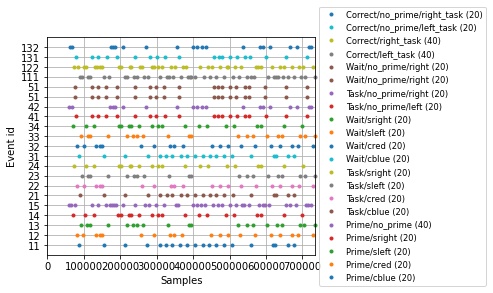

In [23]:
# plotting the events
mne.viz.plot_events(events[0], event_id=event_id);


The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [24]:
# establishing time window
tmin, tmax = -0.2, 0.4
tmin_n, tmax_n = -0.2, 0.7 ### gotta make a time window there is a bit larger, since N400 

# choosing only EEG channels for epoching
picks = mne.pick_types(ica_data_fil.info, meg=False, eeg=True, eog=False)

In [25]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(ica_data_fil, events[0], event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)


epochs_n = mne.Epochs(ica_data_fil, events[0], event_id, tmin_n, tmax_n, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
460 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 460 events and 601 original time points ...
    Rejecting  epoch based on EEG : ['P7']
1 bad epochs dropped
Not setting metadata
460 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 460 events and 901 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['P7']
3 bad epochs dropped


As you can see, we are dropping some epochs that were deeemed 'bad' because they contain values over or under the threshold we defined, allowing us to exclude epochs with artefacts.

## Downsampling
Now we reduce the sample-rate to 250 Hz instead of 600. We do this after epoching, since downsampling before epoching can potentially mess with the precision of the extraction of epochs.

In [26]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

epochs_resampled_n = epochs_n.resample(250)

## Event Related Potentials - ERP
its time to look at the event related potentials ... which mean that we group each epoch by modality and look at the difference between them.

ERP's are event-related voltage changes in the ongoing EEG activity that are time-locked to sensory, motor, and cognitive events. ERPs can be used to identify and classify perceptual, memory and linguistic operations. 
In this case we first look at the number of event's which each matches a specific type of stimulus. 

In [ ]:
epochs_resampled


### ill just save these as a file to make analysis on
#epochs_resampled.save('EPOCHS_wICA-epo.fif')
#epochs_resampled_n.save('EPOCHS_wICA_n400-epo.fif')

### just gotta do the same but for the sake of the permutation test

In [37]:
event_id_p = {'Prime/cblue': 11, # onset blue colour prime
 'Wait/cblue': 31, # onset pause between blue prime and task
 'Prime/cred': 12, # onset red colour prime
 'Wait/cred': 32, # onset pause between blue prime and task
 'Task/colour': 22,
 'Task/colour':21, # onset task after red priming
 'Prime/sleft': 13, # onset left priming
 'Wait/sleft': 33, # onset pause between left prime and task
 'Prime/sright': 14, # onset right priming
 'Wait/sright': 34, # onset pause between blue prime and task
 'Task/spatial': 24, 
 'Task/spatial': 23, # onset task after blue priming
 'Prime/no_prime': 15, # onset right priming
 'Wait/no_prime/left': 51, # onset pause between no prime and left task
 'Wait/no_prime/right': 51, # onset pause between no prime and right task
 'Task/no_prime/left': 41, # onset left_task after no_prime priming
 'Task/no_prime/right': 42, # onset right_task after no_prime priming
 'Correct/left_task': 111, # correct response ('a') to blue or left prime
 'Correct/right_task': 122, # correct response ('l') to red or right prime
 'Correct/no_prime/left_task': 131, # correct response ('a') to no_prime
 'Correct/no_prime/right_task': 132, # correct response ('l') to no_prime
 }

tmin_p, tmax_p = -0.2, 0.7 ### gotta make a time window there is a bit larger, since N400 

# choosing only EEG channels for epoching
picks = mne.pick_types(ica_data_fil.info, meg=False, eeg=True, eog=False)


epochs_p = mne.Epochs(ica_data_fil, events[0], event_id_p, tmin_p, tmax_p, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

resampled_p = epochs_p.resample(250)
resampled_p.save('EPOCHS_permutation-epo.fif')

Not setting metadata
420 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 420 events and 901 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['P7']
3 bad epochs dropped


 Now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index the prime vs actual task from one another ' across the spatial/colour prime. 
 
 I then plot one channel to see the different signal here when you are either colour primed or spatial primed. In this case I go with the Oz since it is placed on the visual cortex. O stands for occipital lobe, in which the visual cortex is located. 

## P100

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


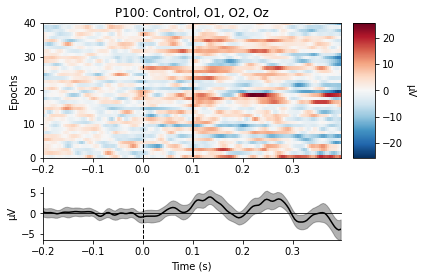

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


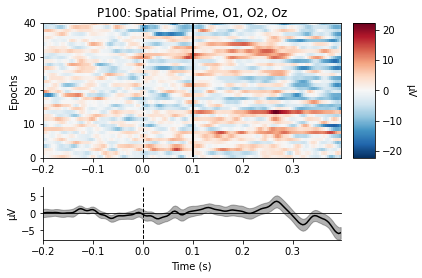

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


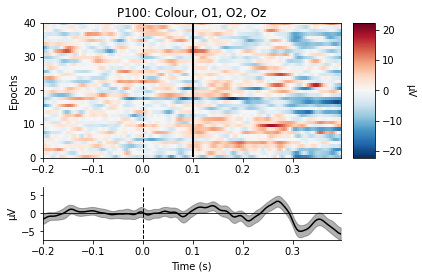

[<Figure size 432x288 with 3 Axes>]

In [ ]:
## Sorting the color and spatial primes from one another.
task_colour_epochs = epochs_resampled['Task/cblue', 'Task/cred']
task_spatial_epochs = epochs_resampled['Task/sleft', 'Task/sright']
task_noprime_epochs = epochs_resampled['Task/no_prime/left', 'Task/no_prime/right', 'Task/no_prime/']

# PLOTTING FOR THE TO
#task_colour_epochs.plot_image(picks=['O1'], title="P100: Colour Prime, O1");
#task_spatial_epochs.plot_image(picks=['O1'], title = "P100: Spatial Prime, O1");
#task_noprime_epochs.plot_image(picks=['O1'], title = "P100: No Prime, O1");

#task_colour_epochs.plot_image(picks=['O2'], title="P100: Colour Prime, O2");
#task_spatial_epochs.plot_image(picks=['O2'], title = "P100: Spatial Prime, O2");
#task_noprime_epochs.plot_image(picks=['O2'], title = "P100: No Prime, O2");

plt_times = np.linspace(0.1,0.1, len(task_noprime_epochs))

### PLOTTING W SEVERAL CHANNELS IN ONE
mne.viz.plot_epochs_image(task_noprime_epochs, group_by={'01, 02, Oz': [27,28,29]}, overlay_times=plt_times, combine = 'mean', title="P100: Control, O1, O2, Oz")
mne.viz.plot_epochs_image(task_spatial_epochs, group_by={'01, 02, Oz': [27,28,29]}, overlay_times=plt_times, combine = 'mean', title="P100: Spatial Prime, O1, O2, Oz")
mne.viz.plot_epochs_image(task_colour_epochs, group_by={'01, 02, Oz': [27,28,29]}, overlay_times=plt_times, combine = 'mean', title="P100: Colour, O1, O2, Oz")




## P200


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


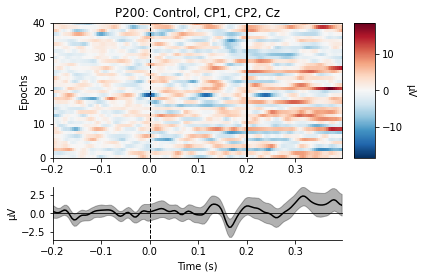

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


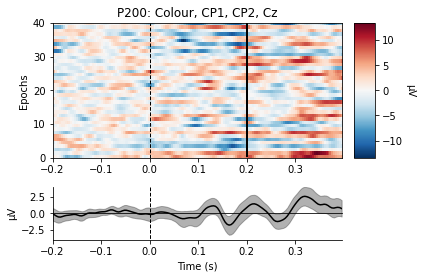

[<Figure size 432x288 with 3 Axes>]

In [ ]:
plt_times = np.linspace(0.2,0.2, len(task_noprime_epochs))

### PLOTTING W SEVERAL CHANNELS IN ONE
mne.viz.plot_epochs_image(task_noprime_epochs, group_by={'CP1, CP2, Cz': [18,19,20]}, overlay_times=plt_times, combine = 'mean', title="P200: Control, CP1, CP2, Cz")
mne.viz.plot_epochs_image(task_spatial_epochs, group_by={'CP1, CP2, Cz': [18,19,20]}, overlay_times=plt_times, combine = 'mean', title="P200: Spatial Prime, CP1, CP2, Cz")
mne.viz.plot_epochs_image(task_colour_epochs, group_by={'CP1, CP2, Cz': [18,19,20]}, overlay_times=plt_times, combine = 'mean', title="P200: Colour, CP1, CP2, Cz")



## N400

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


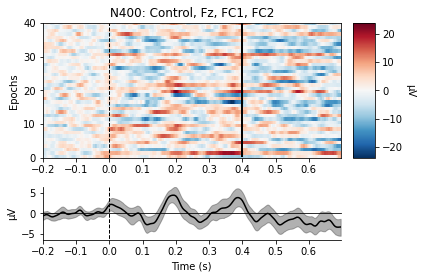

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


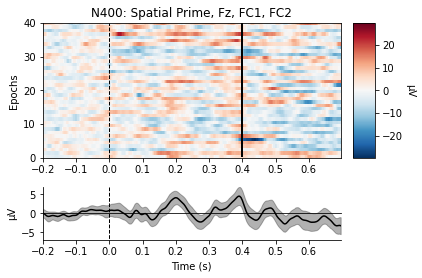

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


[<Figure size 432x288 with 3 Axes>]

In [ ]:
pc_epochs_n = epochs_resampled_n['Task/cblue', 'Task/cred']
ps_epochs_n = epochs_resampled_n['Task/sleft', 'Task/sright']
task_np_epochs_n = epochs_resampled_n['Task/no_prime/left', 'Task/no_prime/right']

# plotting one channel as an example for each modality - THIS TIME FOR N400 
#pc_epochs_n.plot_image(picks=['Fz'], title="N400: Colour Prime, Fz");
#ps_epochs_n.plot_image(picks=['Fz'], title = "N400: Spatial Prime, Fz");
#task_np_epochs_n.plot_image(picks=['Fz'], title = "N400: No Prime, Fz");

#pc_epochs_n.plot_image(picks=['FC2'], title="N400: Colour Prime, FC2");
#ps_epochs_n.plot_image(picks=['FC2'], title = "N400: Spatial Prime, FC2");
#task_np_epochs_n.plot_image(picks=['FC2'], title = "N400: No Prime, FC2");

plt_times = np.linspace(0.400, 0.400, len(task_noprime_epochs))

mne.viz.plot_epochs_image(task_np_epochs_n, group_by={'Fz, FC1, FC2': [4,8,9]}, overlay_times=plt_times, combine = 'mean', title="N400: Control, Fz, FC1, FC2")
mne.viz.plot_epochs_image(ps_epochs_n, group_by={'Fz, FC1, FC2': [4,8,9]}, overlay_times=plt_times,combine = 'mean', title="N400: Spatial Prime, Fz, FC1, FC2")
mne.viz.plot_epochs_image(pc_epochs_n, group_by={'Fz,FC1, FC2': [4,8,9]}, overlay_times=plt_times,combine = 'mean', title="N400: Colour, Fz, FC1, FC2")

The same thing can now be done to make a bit more generalized epochs, namely for all primes and tasks.
We here check how the signal behaves in one channel, the Oz.   

# N170

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


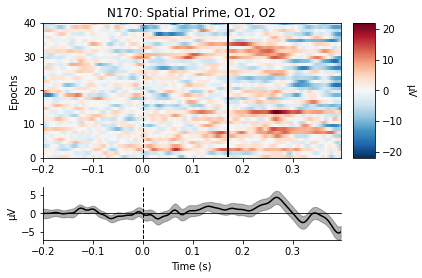

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


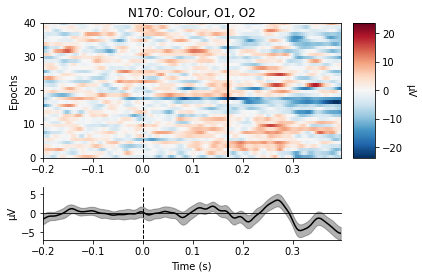

[<Figure size 432x288 with 3 Axes>]

In [ ]:
# PLOTTING FOR THE TO
#prime_colour_epochs.plot_image(picks=['O1'], title="N170: Colour Prime, O1");
#prime_spatial_epochs.plot_image(picks=['O1'], title = "N170: Spatial Prime, O1");
#task_noprime_epochs.plot_image(picks=['O1'], title = "N170: No Prime, O1");

#prime_colour_epochs.plot_image(picks=['Oz'], title="N170: Colour Prime, Oz");
#prime_spatial_epochs.plot_image(picks=['Oz'], title = "N170: Spatial Prime, Oz");
#task_noprime_epochs.plot_image(picks=['Oz'], title = "N170: No Prime, Oz");

plt_times = np.linspace(0.17, 0.17, len(task_noprime_epochs))

mne.viz.plot_epochs_image(task_noprime_epochs, group_by={'01, 02': [27,29]},overlay_times=plt_times, combine = 'mean', title="N170: Control, O1, O2")
mne.viz.plot_epochs_image(task_spatial_epochs, group_by={'01, 02': [27,29]}, overlay_times=plt_times, combine = 'mean', title="N170: Spatial Prime, O1, O2")
mne.viz.plot_epochs_image(task_colour_epochs, group_by={'01, 02': [27,29]}, overlay_times=plt_times, combine = 'mean', title="N170: Colour, O1, O2")



^^^this tells us something about the consistency in the signal

### more genereal conclusion
now we can tell how the task signal in Oz differs quite much from the priming epochs. 


# REACTION TIME over epochs
remember this is on all trials - both with and without priming 

Not setting metadata
460 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 460 events and 1001 original time points ...
    Rejecting  epoch based on EEG : ['T8']
1 bad epochs dropped
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_52846/3435608969.py:17: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.2 s and 0.796 s)
  mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'01, 02, Oz': [27,28,29]}, combine = 'mean', title ='P100: 01, 02, Oz' )


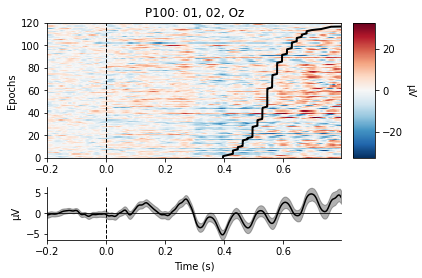

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_52846/3435608969.py:18: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.2 s and 0.796 s)
  mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'CP1, CP2, Cz': [18,19,13]}, combine = 'mean', title ='P200: CP1, CP2, Cz')


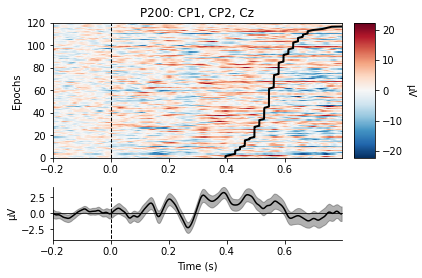

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_52846/3435608969.py:19: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.2 s and 0.796 s)
  mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'01, 02': [27,29]}, combine = 'mean', title ='N170: 01, 02' )


Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_52846/3435608969.py:20: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.2 s and 0.796 s)
  mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'Fz, FC1, FC2': [4,8,9]}, combine = 'mean', title ='N400: Fz, FC1, FC2')


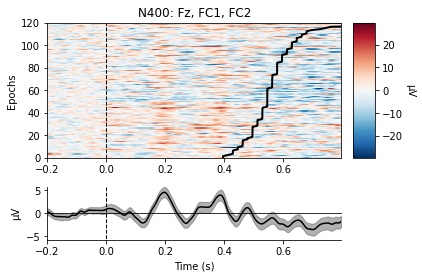

[<Figure size 432x288 with 3 Axes>]

In [ ]:
#### i had to be a bit more large with how many I rejected, since the number of epochs should fit the number of reaction times 
reject_long = dict(eeg=230e-6)

## setting the time window i'd like to see them in
tmin_lo, tmax_lo = -0.2, 0.8
epochs_long = mne.Epochs(ica_data_fil, events[0], event_id, tmin_lo, tmax_lo, picks=picks,
                    baseline=(None, 0), reject=reject_long, preload=True)

## resamling 
ep_l_s = epochs_long.resample(250)

#### making the epochs im interested in - thiis would be all epochs during task settings
plot_epochs = epochs_long['Task/cblue', 'Task/cred', 'Task/sleft', 'Task/sright', 'Task/no_prime/left', 'Task/no_prime/right']


### plotting 
mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'01, 02, Oz': [27,28,29]}, combine = 'mean', title ='P100: 01, 02, Oz' )
mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'CP1, CP2, Cz': [18,19,13]}, combine = 'mean', title ='P200: CP1, CP2, Cz')
mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'01, 02': [27,29]}, combine = 'mean', title ='N170: 01, 02' )
mne.viz.plot_epochs_image(plot_epochs, order=order, overlay_times=overlay_rt_behave, group_by={'Fz, FC1, FC2': [4,8,9]}, combine = 'mean', title ='N400: Fz, FC1, FC2')


## EVOKED EPOCHS
what does evoked mean??? => its just ERP's honey













In [27]:
## EVOKED EPOCHS - general for task and prime
## first we take the epochs based on the trigger, and then we take the avererage of those to get the evoked
prime_epochs = epochs_resampled['Prime']
task_epochs = epochs_resampled['Task']


#### MAKING THE GENERAL EVOKED
task_evoked = task_epochs.average() # [all task]
prime_evoked = prime_epochs.average() # [all prime]


### MAKING EPOCHS FOR ALL THE TRIGGERS COMBINING BY PRIME, TASK, WAIT AND CORRECT

In [28]:
## PRIME EPOCHS Sorting the color and spatial primes from one another.
prime_colour_epochs = epochs_resampled['Prime/cblue', 'Prime/cred']
prime_spatial_epochs = epochs_resampled['Prime/sleft', 'Prime/sright']
prime_no_epochs = epochs_resampled['Prime/no_prime']

# TASK EPOCHS SPATIAL + colour PRIMING
task_spatial_epochs = epochs_resampled['Task/sleft', 'Task/sright']
task_colour_epochs = epochs_resampled['Task/cred', 'Task/cblue']
task_noprime_epochs = epochs_resampled['Task/no_prime/left', 'Task/no_prime/right', 'Task/no_prime/blue', 'Task/no_prime/red']

# WAITING EPOCHS - the waiting time between task + prime
wait_col_prime_epochs = epochs_resampled['Wait/cblue', 'Wait/cred']
wait_spa_prime_epochs = epochs_resampled['Wait/sleft', 'Wait/sright']
wait_no_prime_epochs = epochs_resampled['Wait/no_prime/left', 'Wait/no_prime/right']
# THE RESPOND !!!! 
correct_noprime_epochs = epochs_resampled['Correct/no_prime/left_task', 'Correct/no_prime/right_task']
correct_epochs = epochs_resampled['Correct/left_task', 'Correct/right_task']


### MAKING AN EVOKED FOR EACH EPOCH:

In [29]:
## EVOKED EPOCHS
#### now lets make all of the epochs into evoked epochs, that are ready to become data:

### PRIME
prime_col_evoked = prime_colour_epochs.average()
prime_spa_evoked = prime_spatial_epochs.average()
prime_no_evoked = prime_no_epochs.average()

### TASK 
task_col_evoked = task_colour_epochs.average()
task_spa_evoked = task_spatial_epochs.average() 
task_noprime_evoked = task_noprime_epochs.average()

### WAIT 
wait_col_evoked = wait_col_prime_epochs.average()
wait_spa_evoked = wait_spa_prime_epochs.average()
wait_noprime_evoked = wait_no_prime_epochs.average()

### CORRECT 
correct_evoked = correct_epochs.average()
correct_noprime_evoked = correct_noprime_epochs.average()



### t test between erps???
THIS SHOULD NOT BE DONE - I work with one participant only, thus comparing between ERP would make no sense. I only use them for plots

In [30]:

from scipy import stats as st
import statistics as stats

In [ ]:
colp_task_data = task_col_evoked.get_data(picks=['O1', 'Oz', 'O2'], tmin=.350, tmax=.450)
spap_task_data = task_spa_evoked.get_data(picks=['O1', 'Oz', 'O2'], tmin=.350, tmax=.450)
nop_task_data = task_noprime_evoked.get_data(picks=['O1', 'Oz', 'O2'], tmin=.350, tmax=.450)


since we have already averaged across the number of events, I will now only take the mean of the signal in the three different channels, and then make a comparison of that:

In [ ]:
# COLOUR PRIME VS. NO PRIME
col_task_mean = np.mean(colp_task_data, axis=0) 
no_prime_mean = np.mean(nop_task_data, axis=0)

st.ttest_ind(a=no_prime_mean, b=col_task_mean)

NameError: name 'st' is not defined

In [ ]:
# SPATIAL PRIME VS. NO PRIME
spa_task_mean = np.mean(spap_task_data, axis=0) 

st.ttest_ind(a=no_prime_mean, b=spa_task_mean)

Ttest_indResult(statistic=0.9499430920840931, pvalue=0.34689986728840005)

In [ ]:
# SPATIAL VS. COLOR PRIME
st.ttest_ind(a=col_task_mean, b=spa_task_mean)

Ttest_indResult(statistic=-0.28653180775082665, pvalue=0.7757039916035009)


## PLOTTING THE ERP'SSS
Now that I have the evoked, I can plot and compare the signals 

### P100

## N400

# n170

In [31]:
# MAKE EVOKED FOR EPOCH_RESAMPLED_N DATA:
ts_epochs = epochs_resampled_n['Task/sleft', 'Task/sright']
tc_epochs = epochs_resampled_n['Task/cred', 'Task/cblue']
tnp_epochs = epochs_resampled_n['Task/no_prime/left', 'Task/no_prime/right', 'Task/no_prime/blue', 'Task/no_prime/red']

ts_evoked = ts_epochs.average()
tc_evoked = tc_epochs.average()
tnp_evoked = tnp_epochs.average()



combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


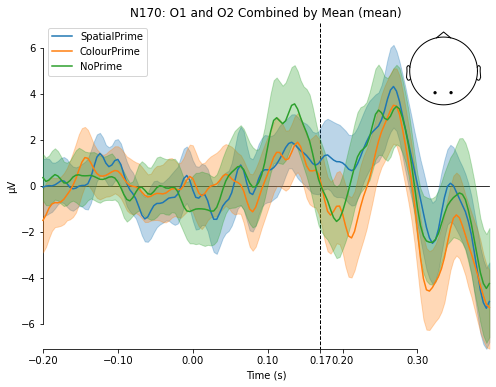

[<Figure size 576x432 with 2 Axes>]

In [ ]:

evokeds_con = dict(SpatialPrime=list(epochs_resampled['Task/sleft', 'Task/sright'].iter_evoked()),
               ColourPrime=list(epochs_resampled['Task/cred', 'Task/cblue'].iter_evoked()),
               NoPrime=list(epochs_resampled['Task/no_prime/left', 'Task/no_prime/right', 'Task/no_prime/blue', 'Task/no_prime/red'].iter_evoked()))


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


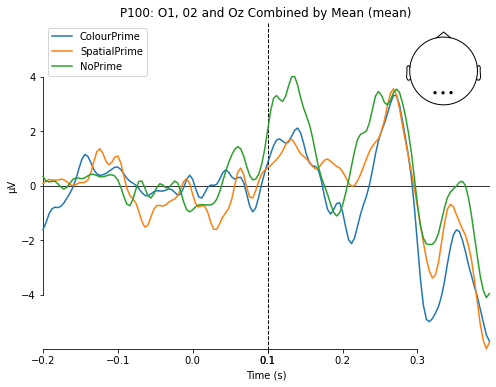

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


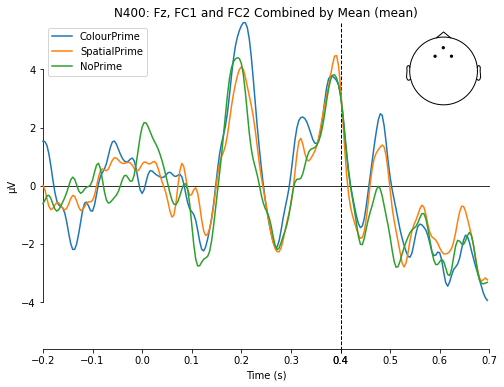

[<Figure size 576x432 with 2 Axes>]

In [32]:


# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(ColourPrime = task_col_evoked , SpatialPrime =task_spa_evoked, NoPrime = task_noprime_evoked), picks=['O1', 'Oz', 'O2'],
                             legend='upper left', show_sensors='upper right', title = "P100: O1, 02 and Oz Combined by Mean", vlines=[0.1], combine = 'mean')

# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(ColourPrime = task_col_evoked , SpatialPrime =task_spa_evoked, NoPrime = task_noprime_evoked), picks=['CP1', 'CP2', 'Cz'],
                             legend='upper left', show_sensors='upper right', title = "P200: CP1, CP2 and Cz Combined by Mean", vlines=[0.2], combine = 'mean')

# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(ColourPrime = task_col_evoked , SpatialPrime =task_spa_evoked, NoPrime = task_noprime_evoked), picks=['O1', 'O2'],
                             legend='upper left', show_sensors='upper right', title = "N170: O1 and O2 Combined by Mean", vlines=[0.17], combine = 'mean')


# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(ColourPrime = tc_evoked , SpatialPrime =ts_evoked, NoPrime = tnp_evoked), picks=['Fz', 'FC1', 'FC2'],
                             legend='upper left', show_sensors='upper right', title = "N400: Fz, FC1 and FC2 Combined by Mean", vlines=[0.4], combine = 'mean')

In [ ]:
### making confidence intervals possible for n400
evokeds_con400 = dict(SpatialPrime=list(epochs_resampled_n['Task/sleft', 'Task/sright'].iter_evoked()),
               ColourPrime=list(epochs_resampled_n['Task/cred', 'Task/cblue'].iter_evoked()),
               NoPrime=list(epochs_resampled_n['Task/no_prime/left', 'Task/no_prime/right', 'Task/no_prime/blue', 'Task/no_prime/red'].iter_evoked()))


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


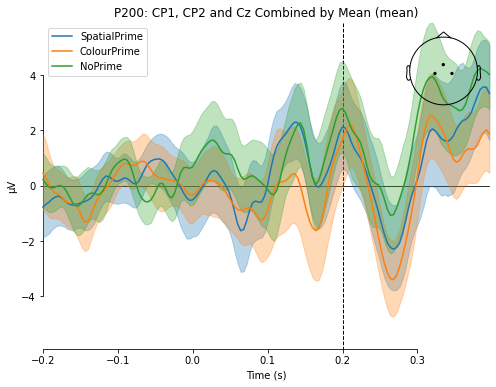

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


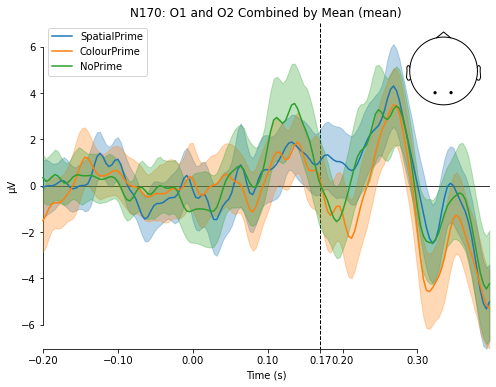

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


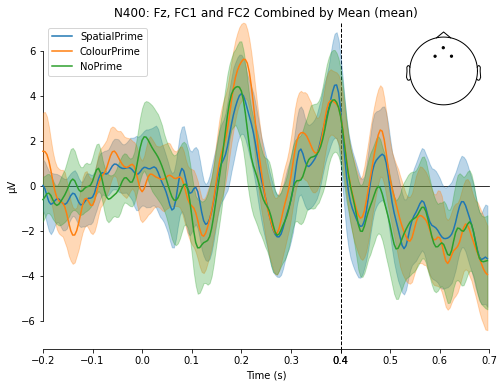

[<Figure size 576x432 with 2 Axes>]

In [ ]:


# plotting the two evokeds together
mne.viz.plot_compare_evokeds(evokeds_con, picks=['O1', 'Oz', 'O2'],
                             legend='upper left', show_sensors='upper right', title = "P100: O1, 02 and Oz Combined by Mean", vlines=[0.1], combine = 'mean')

# plotting the two evokeds together
mne.viz.plot_compare_evokeds(evokeds_con, picks=['CP1', 'CP2', 'Cz'],
                             legend='upper left', show_sensors='upper right', title = "P200: CP1, CP2 and Cz Combined by Mean", vlines=[0.2], combine = 'mean')

# plotting the two evokeds together
mne.viz.plot_compare_evokeds(evokeds_con, picks=['O1', 'O2'],
                             legend='upper left', show_sensors='upper right', title = "N170: O1 and O2 Combined by Mean", vlines=[0.17], combine = 'mean')


# plotting the two evokeds together
mne.viz.plot_compare_evokeds(evokeds_con400, picks=['Fz', 'FC1', 'FC2'],
                             legend='upper left', show_sensors='upper right', title = "N400: Fz, FC1 and FC2 Combined by Mean", vlines=[0.4], combine = 'mean')

Looking a bit closer at the averaged responses, here visualized with the gfp (global field power).

GFP is actually the same as taking the standard deviation across all channels in each time sample. This tells us in which timepoints we see the biggest difference between different channels, which in turn is indicative of some kind of (more or less) focal activity. Quite neat actually.

Looking at the plot, where in time do you see the strongest response in the auditory and visual conditions, respectively?
Do those timepoints match any well-known components relevant in this context? 


### JOINT EVOKED PLOTS

Now compare with the "joint" plots below - do those plots match your observations from the GFP-plots?

##### topo map time
This tells us something about at what time we can see the different signals over the entire brain:

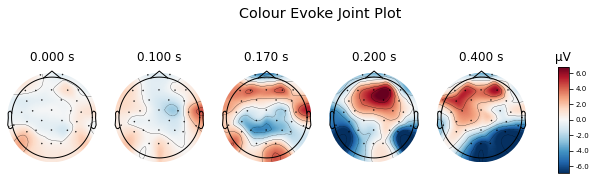

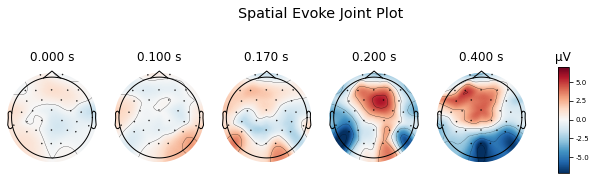

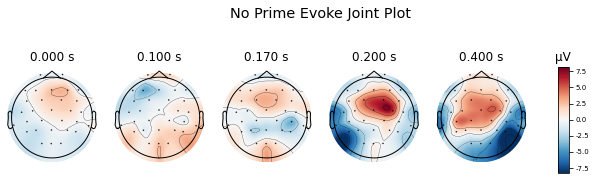

In [ ]:
tc_evoked.plot_topomap(times=[0., 0.1, 0.17, 0.2, 0.4], ch_type='eeg', title = "Colour Evoke Joint Plot");
ts_evoked.plot_topomap(times=[0., 0.1, 0.17, 0.2, 0.4], ch_type='eeg', title = "Spatial Evoke Joint Plot");
tnp_evoked.plot_topomap(times=[0., 0.1, 0.17, 0.2, 0.4], ch_type='eeg', title = "No Prime Evoke Joint Plot");

#### joint evoked cool plots

No projector specified for this dataset. Please consider the method self.add_proj.


No projector specified for this dataset. Please consider the method self.add_proj.


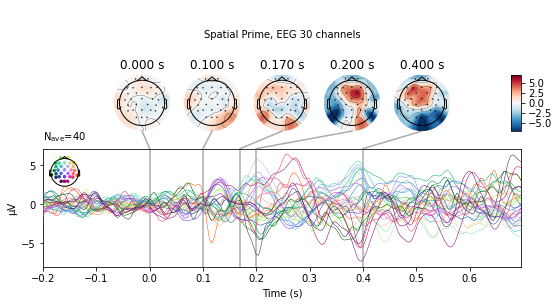

No projector specified for this dataset. Please consider the method self.add_proj.


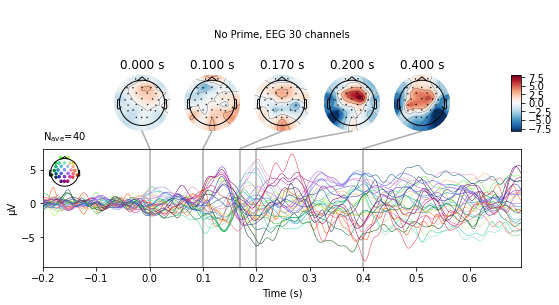

In [ ]:
tc_evoked.plot_joint(picks='eeg', title = "Colour Prime, EEG 30 channels",times=[0., 0.1, 0.17, 0.2,0.4] );
ts_evoked.plot_joint(picks='eeg', title = "Spatial Prime, EEG 30 channels",times=[0., 0.1, 0.17, 0.2,0.4]);
tnp_evoked.plot_joint(picks='eeg', title = "No Prime, EEG 30 channels",times=[0., 0.1, 0.17, 0.2,0.4]);

As a final note, we can create contrasts (aka. difference waves) on the fly by using the combine_evoked-function (in combination with the weights=[1, -1]-parameter).

This also gives us a chance to try out one final plotting function, namely the plot_topo-function. This function plots the difference waves (or whichever traces we choose to plot) for each channel in their positions on the scalp.

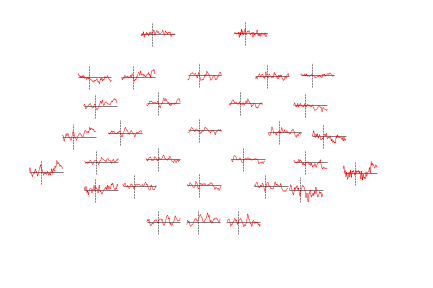

In [ ]:
evoked_diff = mne.combine_evoked([prime_spa_evoked, prime_col_evoked], weights=[1, -1])
evoked_diff.pick_types(eeg=True).plot_topo(color='r', legend=False);